In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import os
import boto3
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
import numpy as np

In [3]:
def maybe_pickle(data, filename, force=False):
    if os.path.exists(filename) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping pickling.' % filename)
    else:
        print('Pickling %s.' % filename)
        try:
            with open(filename, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', filename, ':', e)


def maybe_download(table, force=False):
    storage_file = table + ".pkl"
    if force or not os.path.exists(storage_file):
        data = data_retrieve(table)
        maybe_pickle(data, storage_file)
    return storage_file
        
def data_retrieve(table, page_size=100):
    """download data from table"""
    client = boto3.client('dynamodb')
    paginator = client.get_paginator('scan')

    counter = 0
    items = []
    for page in paginator.paginate(TableName=table, PaginationConfig={"PageSize": page_size}):
        items.extend(page["Items"])
        
        counter += 1
        if counter % 50 == 0:  # print debug every 50 pages
            print("items: {}. next page. {}. Count {}. ScannedCount: {}".format(len(items), counter, page["Count"], page["ScannedCount"]))


    return items
    

In [4]:
data_file = maybe_download("apthunt")
data = pickle.load(open(data_file, 'rb'))

In [5]:
print("wow")

wow


In [6]:
# To go from dynamo format to python
from boto3.dynamodb import types

deserializer = types.TypeDeserializer()
python_data = [{k: deserializer.deserialize(v) for k,v in d.items()} for d in data]

In [7]:
del data

In [8]:
df = pd.DataFrame(python_data)

In [9]:
del python_data

In [10]:
with open("df.pkl", 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)


In [11]:
df = pickle.load(open("df.pkl", 'rb'))

In [12]:
df.head()

,parsed_postingtitletext,parsed_map_address,added,PostUrl,PostTitle,parsed_price,parsed_price_text,parsed_housing,PostContent,parsed_data_longitude,...,parsed_postingbody,parsed_page_head,parsed_thumbs,FeedTitle,parsed_titletextonly,intid,parsed_data_latitude,FeedUrl,PostPublished,parsed_notices
0,$3150 / 2br - 1300ft2 - Sunset Oaks Townhome- ...,1249 Crescent Terrace,1538706586266,https://sfbay.craigslist.org/sby/apa/d/sunset-...,simulated,3150,$3150,2br - 1300ft2,simulated,-122.026428,...,"Well designed and spacious 2 bedroom, 2 1/2 ba...",None,[https://images.craigslist.org/00Z0Z_5KZmIXxAc...,simulated,Sunset Oaks Townhome- 1249 Crescent Terrace - ...,6aea5603583644368e76bac8293aa38a,37.353754,simulated,simulated,[do NOT contact me with unsolicited services o...
1,$1769 / 2br - 875ft2 - ❄ Pittsburg Apartment L...,2205 E Leland Rd,1539451812116,https://sfbay.craigslist.org/eby/apa/d/pittsbu...,simulated,1769,$1769,2br - 875ft2,simulated,-121.864673,...,Diamond Hillside Apartment Homes offers spacio...,None,[https://images.craigslist.org/00c0c_505E4utDZ...,simulated,"❄ Pittsburg Apartment Living, Gated Community,...",0f490163255448ac973218ae45b7fa99,38.008321,simulated,simulated,[do NOT contact me with unsolicited services o...
2,$3000 / 2br - 1800ft2 - 2 Bedroom 1 Bath 1 Car...,375 Pope Street,1538947757137,https://sfbay.craigslist.org/sfc/apa/d/2-bedro...,simulated,3000,$3000,2br - 1800ft2,simulated,-122.439706,...,clean 2 Bedroom 1 full bathroom 1 car garage. ...,None,[https://images.craigslist.org/00G0G_2bsd96Q2m...,simulated,2 Bedroom 1 Bath 1 Car Garage House,ef4a3ac21bca461bab5364dbda00144c,37.710526,simulated,simulated,[do NOT contact me with unsolicited services o...
3,$2150 / 3br - 1200ft2 - Updated 1200 SQ FT 3 B...,2436 Baltic Dr,1585287116209,https://sfbay.craigslist.org/eby/apa/d/fairfie...,simulated,2150,$2150,3br - 1200ft2,simulated,-122.019156,...,Updated 1200 SQ FT 3 Bed 1.5 Bath 2-story hous...,None,[https://images.craigslist.org/00s0s_fp0FHrerE...,simulated,Updated 1200 SQ FT 3 Bed 1.5 Bath 2-story hous...,bad01973976c49a88c0f45894ae19cc3,38.27479,simulated,simulated,[do NOT contact me with unsolicited services o...
4,$2150 / 1br - 726ft2 - FULLY RENOVATED 1BED 1B...,1182 E Street near 2nd,1587684611249,https://sfbay.craigslist.org/eby/apa/d/hayward...,simulated,2150,$2150,1br - 726ft2,simulated,-122.076737,...,Beautiful Fully Renovated 1 bedroom 1 bathroom...,None,[https://images.craigslist.org/01010_IJCcnFKWL...,simulated,FULLY RENOVATED 1BED 1BATH IN HAYWARD! PRE-LEA...,51f6a9ed9e224966b5fe96faf83521a1,37.671644,simulated,simulated,[do NOT contact me with unsolicited services o...


In [13]:
df["parsed_page_head"].describe()

count                                                  5856
unique                                                 5049
top       "FULLY REMODELED" 3 Bed, 1 Bath, Duplex - apts...
freq                                                     15
Name: parsed_page_head, dtype: object

In [14]:
# small cleanup of "simulated"
del df["FeedTitle"]
del df["FeedUrl"]
del df["PostContent"]
del df["PostPublished"]
del df["PostTitle"]
# delete parsed_notices. looks like it is the same
del df["parsed_notices"]
# no need for price text
del df["parsed_price_text"]

In [15]:
df.columns

Index(['parsed_postingtitletext', 'parsed_map_address', 'added', 'PostUrl',
       'parsed_price', 'parsed_housing', 'parsed_data_longitude',
       'parsed_attrs', 'parsed_district', 'parsed_map_link',
       'parsed_postingbody', 'parsed_page_head', 'parsed_thumbs',
       'parsed_titletextonly', 'intid', 'parsed_data_latitude'],
      dtype='object')

In [16]:
# for col in df.columns:
#     print(col)
#     print(df[col].describe())
#     print(df[col].head())
#     print("=" * 60)

In [17]:
def clean_parsed_args(args):
    if not isinstance(args, list):
        return []
    clean = []
    for p in args:
        # remove days
        if p.startswith("friday") or p.startswith("monday") or p.startswith("saturday") or p.startswith("sunday") or p.startswith("thursday") or p.startswith("tuesday") or p.startswith("wednesday"):
            continue
        # remove br/ba
        if "BR / " in p: continue
        # remove ft2
        if p.endswith("ft2"): continue

        # remove application fee
        if p.startswith("application fee"): continue
        
        # remove broker fee
        if p.startswith("broker fee"): continue
        
        # remove available
        if p.startswith("available"): continue
        
        # remove listed by
        if p.startswith("listed by"): continue
        clean.append(p)
    return clean
        

In [18]:
aa = []
for i in df['parsed_attrs']:
    if isinstance(i, list): aa.extend(i)

for i in sorted(set(clean_parsed_args(aa))):
    print(i)
    

EV charging
apartment
assisted living
attached garage
carport
cats are OK - purrr
condo
cottage/cabin
detached garage
dogs are OK - wooof
duplex
flat
furnished
house
in-law
land
laundry in bldg
laundry on site
loft
manufactured
no laundry on site
no parking
no smoking
off-street parking
street parking
townhouse
valet parking
w/d hookups
w/d in unit
wheelchair accessible


In [19]:
df['parsed_attrs'] = df['parsed_attrs'].map(clean_parsed_args)
# one_hot = pd.get_dummies(df['parsed_attrs'])

In [20]:
df['parsed_attrs']

0         [townhouse, w/d in unit, no smoking, detached ...
1                                               [apartment]
2         [house, laundry in bldg, no smoking, attached ...
3                     [house, w/d hookups, detached garage]
4         [cats are OK - purrr, dogs are OK - wooof, apa...
                                ...                        
843726    [cats are OK - purrr, apartment, laundry on si...
843727    [townhouse, w/d in unit, no smoking, detached ...
843728                                                   []
843729    [cats are OK - purrr, dogs are OK - wooof, fur...
843730        [apartment, laundry on site, detached garage]
Name: parsed_attrs, Length: 843731, dtype: object

In [21]:
df.head()

,parsed_postingtitletext,parsed_map_address,added,PostUrl,parsed_price,parsed_housing,parsed_data_longitude,parsed_attrs,parsed_district,parsed_map_link,parsed_postingbody,parsed_page_head,parsed_thumbs,parsed_titletextonly,intid,parsed_data_latitude
0,$3150 / 2br - 1300ft2 - Sunset Oaks Townhome- ...,1249 Crescent Terrace,1538706586266,https://sfbay.craigslist.org/sby/apa/d/sunset-...,3150,2br - 1300ft2,-122.026428,"[townhouse, w/d in unit, no smoking, detached ...",sunnyvale,https://maps.google.com/?q=loc%3A+%31%32%34%39...,"Well designed and spacious 2 bedroom, 2 1/2 ba...",None,[https://images.craigslist.org/00Z0Z_5KZmIXxAc...,Sunset Oaks Townhome- 1249 Crescent Terrace - ...,6aea5603583644368e76bac8293aa38a,37.353754
1,$1769 / 2br - 875ft2 - ❄ Pittsburg Apartment L...,2205 E Leland Rd,1539451812116,https://sfbay.craigslist.org/eby/apa/d/pittsbu...,1769,2br - 875ft2,-121.864673,[apartment],"Pittsburg, CA",https://maps.google.com/?q=loc%3A+%32%32%30%35...,Diamond Hillside Apartment Homes offers spacio...,None,[https://images.craigslist.org/00c0c_505E4utDZ...,"❄ Pittsburg Apartment Living, Gated Community,...",0f490163255448ac973218ae45b7fa99,38.008321
2,$3000 / 2br - 1800ft2 - 2 Bedroom 1 Bath 1 Car...,375 Pope Street,1538947757137,https://sfbay.craigslist.org/sfc/apa/d/2-bedro...,3000,2br - 1800ft2,-122.439706,"[house, laundry in bldg, no smoking, attached ...",excelsior / outer mission,https://maps.google.com/?q=loc%3A+%33%37%35+Po...,clean 2 Bedroom 1 full bathroom 1 car garage. ...,None,[https://images.craigslist.org/00G0G_2bsd96Q2m...,2 Bedroom 1 Bath 1 Car Garage House,ef4a3ac21bca461bab5364dbda00144c,37.710526
3,$2150 / 3br - 1200ft2 - Updated 1200 SQ FT 3 B...,2436 Baltic Dr,1585287116209,https://sfbay.craigslist.org/eby/apa/d/fairfie...,2150,3br - 1200ft2,-122.019156,"[house, w/d hookups, detached garage]",fairfield / vacaville,"https://www.google.com/maps/search/38.274790,-...",Updated 1200 SQ FT 3 Bed 1.5 Bath 2-story hous...,None,[https://images.craigslist.org/00s0s_fp0FHrerE...,Updated 1200 SQ FT 3 Bed 1.5 Bath 2-story hous...,bad01973976c49a88c0f45894ae19cc3,38.27479
4,$2150 / 1br - 726ft2 - FULLY RENOVATED 1BED 1B...,1182 E Street near 2nd,1587684611249,https://sfbay.craigslist.org/eby/apa/d/hayward...,2150,1br - 726ft2,-122.076737,"[cats are OK - purrr, dogs are OK - wooof, apa...",hayward / castro valley,"https://www.google.com/maps/search/37.671644,-...",Beautiful Fully Renovated 1 bedroom 1 bathroom...,None,[https://images.craigslist.org/01010_IJCcnFKWL...,FULLY RENOVATED 1BED 1BATH IN HAYWARD! PRE-LEA...,51f6a9ed9e224966b5fe96faf83521a1,37.671644


In [22]:
df.shape

(843731, 16)

In [23]:
def get_type(attrs):
    if not isinstance(attrs, list):
        return None
    types = set([
        "apartment", 
        "townhouse", 
        "loft", 
        "land", 
        "house", 
        "duplex", 
        "flat", 
        "condo", 
        "cottage/cabin"
    ])
    return ",".join(sorted(types & set(attrs)))

In [24]:
def prepare_data(df):
    new  = pd.DataFrame()
    new["latitude"] = df["parsed_data_latitude"]
    new["longitude"] = df["parsed_data_longitude"]
    new["district"] = df["parsed_district"].map(lambda s: s.strip("()") if isinstance(s, str) else s)
    new["address"] = df["parsed_map_address"].map(lambda x: x if x != "(google map)" else None)
    new["housing"] = df["parsed_housing"]
    
    new["price"] = df["parsed_price"].map(lambda x: float(x) if x else x)
    
    # to numerical values
    new['price'] = pd.to_numeric(new['price'])
    new['longitude'] = pd.to_numeric(new['longitude'])
    new['latitude'] = pd.to_numeric(new['latitude'])
    
    new['bedrooms'] = new['housing'].str.extract('(\d+)br\s.*', expand=True)
    new['bedrooms'] = pd.to_numeric(new['bedrooms'])
    
    new['area'] = new['housing'].str.extract('(\d+)ft2', expand=True)
    new['area'] = pd.to_numeric(new['area'])
    
    new['type'] = df["parsed_attrs"].map(get_type)
    new['catsok'] = df["parsed_attrs"].map(lambda x: "cats are OK - purrr" in x)
    new['dogsok'] = df["parsed_attrs"].map(lambda x: "dogs are OK - wooof" in x)
    new['garagea'] = df["parsed_attrs"].map(lambda x: "attached garage" in x)
    new['garaged'] = df["parsed_attrs"].map(lambda x: "detached garage" in x)
    new['furnished'] = df["parsed_attrs"].map(lambda x: "furnished" in x)
    
    new['laundryb'] = df["parsed_attrs"].map(lambda x: "laundry in bldg" in x)
    new['laundrys'] = df["parsed_attrs"].map(lambda x: "laundry on site" in x)
    
    new['wd'] = df["parsed_attrs"].map(lambda x: "w/d in unit" in x)

    return new

In [35]:
short = prepare_data(df)

In [36]:
short

,latitude,longitude,district,address,housing,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd
0,37.353754,-122.026428,sunnyvale,1249 Crescent Terrace,2br - 1300ft2,3150.0,2.0,1300.0,townhouse,False,False,False,True,False,False,False,True
1,38.008321,-121.864673,"Pittsburg, CA",2205 E Leland Rd,2br - 875ft2,1769.0,2.0,875.0,apartment,False,False,False,False,False,False,False,False
2,37.710526,-122.439706,excelsior / outer mission,375 Pope Street,2br - 1800ft2,3000.0,2.0,1800.0,house,False,False,True,False,False,True,False,False
3,38.274790,-122.019156,fairfield / vacaville,2436 Baltic Dr,3br - 1200ft2,2150.0,3.0,1200.0,house,False,False,False,True,False,False,False,False
4,37.671644,-122.076737,hayward / castro valley,1182 E Street near 2nd,1br - 726ft2,2150.0,1.0,726.0,apartment,True,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843726,37.337841,-121.978369,santa clara,2865 Homestead Rd,1br - 750ft2,2195.0,1.0,750.0,apartment,True,False,False,False,False,False,True,False
843727,37.552033,-121.996875,fremont / union city / newark,4095 EGGERS DR,2br - 1000ft2,2800.0,2.0,1000.0,townhouse,False,False,False,True,False,False,False,True
843728,NaN,NaN,fairfield / vacaville,NaN,/ 2br - 918ft2 -,1965.0,2.0,918.0,,False,False,False,False,False,False,False,False
843729,37.787295,-122.392719,Rincon Hill,"340 Fremont St, San Francisco, CA 94105, USA",1br - 708ft2,4890.0,1.0,708.0,apartment,True,True,False,False,True,False,False,True


In [37]:
short.shape

(843731, 17)

In [38]:
del short["housing"]
del short["address"]

In [39]:
short.dtypes

latitude     float64
longitude    float64
district      object
price        float64
bedrooms     float64
area         float64
type          object
catsok          bool
dogsok          bool
garagea         bool
garaged         bool
furnished       bool
laundryb        bool
laundrys        bool
wd              bool
dtype: object

In [40]:
short

,latitude,longitude,district,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd
0,37.353754,-122.026428,sunnyvale,3150.0,2.0,1300.0,townhouse,False,False,False,True,False,False,False,True
1,38.008321,-121.864673,"Pittsburg, CA",1769.0,2.0,875.0,apartment,False,False,False,False,False,False,False,False
2,37.710526,-122.439706,excelsior / outer mission,3000.0,2.0,1800.0,house,False,False,True,False,False,True,False,False
3,38.274790,-122.019156,fairfield / vacaville,2150.0,3.0,1200.0,house,False,False,False,True,False,False,False,False
4,37.671644,-122.076737,hayward / castro valley,2150.0,1.0,726.0,apartment,True,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843726,37.337841,-121.978369,santa clara,2195.0,1.0,750.0,apartment,True,False,False,False,False,False,True,False
843727,37.552033,-121.996875,fremont / union city / newark,2800.0,2.0,1000.0,townhouse,False,False,False,True,False,False,False,True
843728,NaN,NaN,fairfield / vacaville,1965.0,2.0,918.0,,False,False,False,False,False,False,False,False
843729,37.787295,-122.392719,Rincon Hill,4890.0,1.0,708.0,apartment,True,True,False,False,True,False,False,True


In [41]:
short.shape

(843731, 15)

In [42]:
short.dropna(subset=["price"], inplace=True)
short.shape

(838998, 15)

In [143]:
# short.dropna(inplace=True)
# short.shape

In [43]:
short.drop_duplicates(inplace=True)
short.shape

(354318, 15)

In [53]:
short['price_bucket'] = short['price'].apply(lambda x: f"{x//500:02.0f}x500")

In [54]:
short.head()

,latitude,longitude,district,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd,price_bucket
0,37.353754,-122.026428,sunnyvale,3150.0,2.0,1300.0,townhouse,False,False,False,True,False,False,False,True,06x500
1,38.008321,-121.864673,"Pittsburg, CA",1769.0,2.0,875.0,apartment,False,False,False,False,False,False,False,False,03x500
2,37.710526,-122.439706,excelsior / outer mission,3000.0,2.0,1800.0,house,False,False,True,False,False,True,False,False,06x500
3,38.274790,-122.019156,fairfield / vacaville,2150.0,3.0,1200.0,house,False,False,False,True,False,False,False,False,04x500
4,37.671644,-122.076737,hayward / castro valley,2150.0,1.0,726.0,apartment,True,True,False,False,False,False,False,True,04x500


In [105]:
short[short["price"] > 8000].shape

(0, 16)

In [102]:
# short = short.drop(.index)
# df = df.drop(df[<some boolean condition>].index)
short = short.drop(short[short["price"] > 8000].index)
short.shape

(350647, 16)

In [103]:
short["bedrooms"].unique()

array([  2.,   3.,   1.,  nan,   4.,   6.,   5.,   7.,   8., 123.])

In [84]:
short.dtypes

latitude        float64
longitude       float64
district         object
price           float64
bedrooms        float64
area            float64
type             object
catsok             bool
dogsok             bool
garagea            bool
garaged            bool
furnished          bool
laundryb           bool
laundrys           bool
wd                 bool
price_bucket     object
dtype: object

In [104]:
short["price_bucket"].describe()

count     350647
unique        17
top       05x500
freq       72604
Name: price_bucket, dtype: object

In [99]:
short["price_bucket"].unique()

array(['06x500', '03x500', '04x500', '08x500', '07x500', '05x500',
       '11x500', '02x500', '01x500', '00x500', '13x500', '09x500',
       '12x500', '10x500', '17x500', '15x500', '19x500', '21x500',
       '14x500', '23x500', '16x500', '20x500', '18x500', '24x500',
       '27x500', '30x500', '29x500', '28x500', '22x500', '25x500',
       '26x500'], dtype=object)

In [107]:
short.to_csv("data.csv", index=False) 

In [45]:
del short

In [46]:
df[df['parsed_price'] == 7072899529].values

array([['$7072899529 / 2br - 516ft2 - GORGEOUS 2X2 WITH FULL SIZE WASHER & DRYER (napa county) hide this posting unhide',
        '5500 Eucalyptus Drive', Decimal('1541814393509'),
        'https://sfbay.craigslist.org/nby/apa/d/gorgeous-2x2-with-full-size/6745199759.html',
        Decimal('7072899529'), '2br - 516ft2', Decimal('-122.256082'),
        list(['2BR / 2Ba', '516ft2', 'available nov 9', 'cats are OK - purrr', 'dogs are OK - wooof', 'apartment', 'w/d in unit', 'carport']),
        'napa county',
        'https://maps.google.com/?q=loc%3A+%35%35%30%30+Eucalyptus+Drive+American+Canyon+CA+US',
        '2 \xa0bedroom 2 bath 1085Sq.Ft. $2,253 - $2,624/mo\nThe Lodge At Napa Junction\nCALL US TODAY: show contact info x516\nDESCRIPTION:\nExperience the best in luxury apartment living in American Canyon, thanks to this two-bedroom, two-bathroom floor plan from The Lodge at Napa Junction. Along with a fireplace in select homes, the layout includes a built-in desk nook in the kitchen a

In [47]:
p = df["parsed_price"].dropna().map(float)
p.describe()


count    8.389980e+05
mean     3.575694e+14
std      3.275222e+17
min      0.000000e+00
25%      2.095000e+03
50%      2.656000e+03
75%      3.495000e+03
max      3.000000e+20
Name: parsed_price, dtype: float64

In [48]:
p.quantile([0.5, 0.75, 0.8, 0.9, 1.0])

0.50    2.656000e+03
0.75    3.495000e+03
0.80    3.700000e+03
0.90    4.500000e+03
1.00    3.000000e+20
Name: parsed_price, dtype: float64

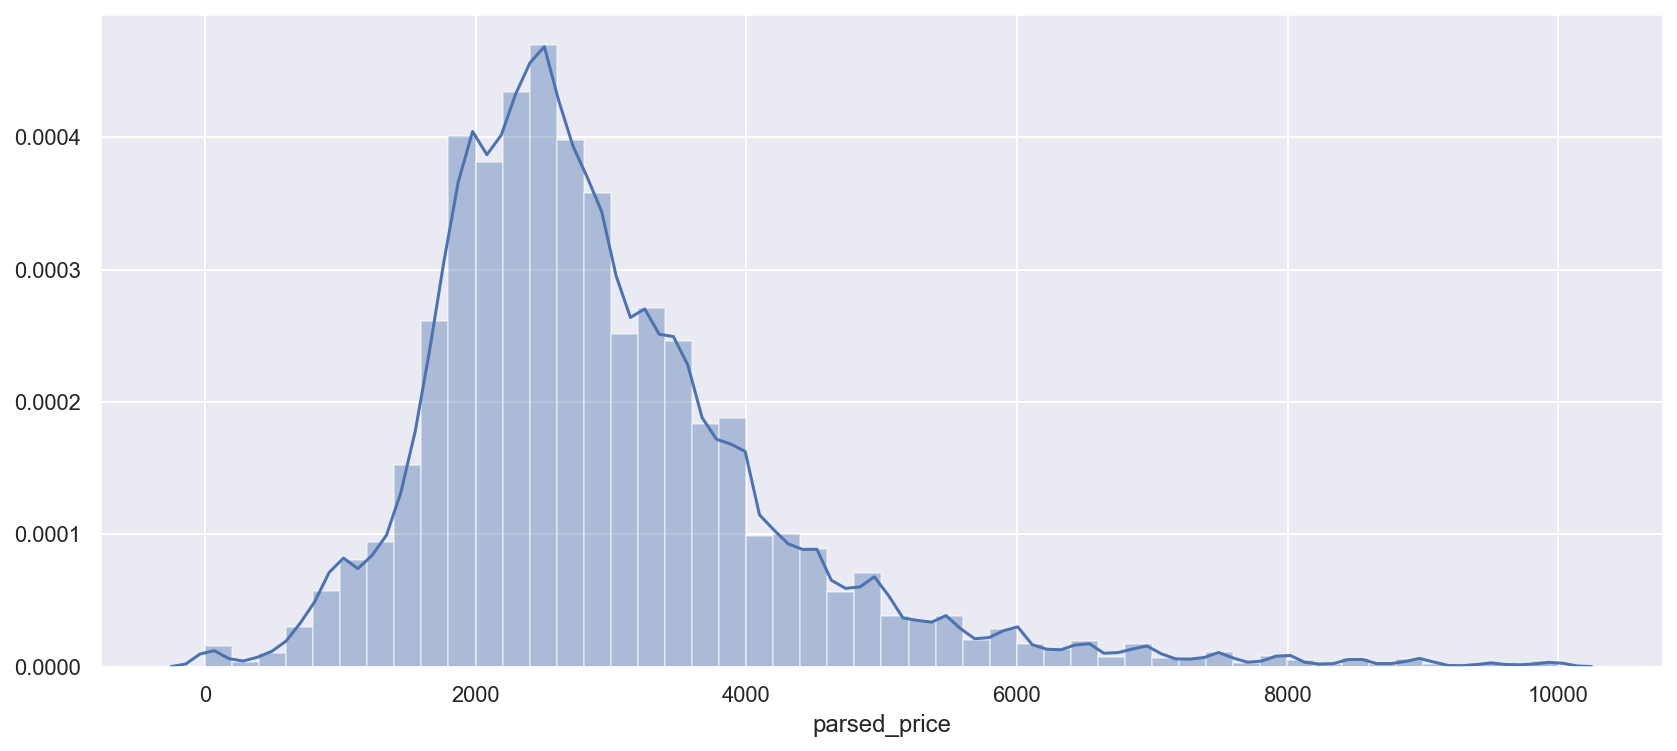

In [49]:
sns.set(color_codes=True)
plt.figure(figsize=(14, 6))

g = sns.distplot(p[p < 10000]);
# g = sns.distplot(p);

In [50]:
p[p < 60000].describe()

count    838813.000000
mean       2977.999570
std        1728.314742
min           0.000000
25%        2095.000000
50%        2655.000000
75%        3495.000000
max       59000.000000
Name: parsed_price, dtype: float64

In [51]:
p[p<1000].sort_values()


53525       0.0
747739      0.0
503351      0.0
15258       0.0
568709      0.0
          ...  
410796    999.0
41346     999.0
546363    999.0
165607    999.0
459056    999.0
Name: parsed_price, Length: 19333, dtype: float64

In [52]:
pid = 344311
print(df.iloc[pid])
print(df.iloc[pid]["PostUrl"])
print(df.iloc[pid]["parsed_thumbs"])

parsed_postingtitletext    $3472 / 1br - 685ft2 - 2 WEEKS FREE!!! Resort ...
parsed_map_address                                           300 Railway Ave
added                                                          1572742708539
PostUrl                    https://sfbay.craigslist.org/sby/apa/d/campbel...
parsed_price                                                            3472
parsed_housing                                                  1br - 685ft2
parsed_data_longitude                                            -121.944669
parsed_attrs               [1BR / 1Ba, 685ft2, available nov 2, sunday 20...
parsed_district                                                     Campbell
parsed_map_link            https://www.google.com/maps/preview/@37.283326...
parsed_postingbody         Now open for tours! At 300 Railway, each resid...
parsed_page_head                                                        None
parsed_thumbs              [https://images.craigslist.org/00909_6B4ImEqVl...

In [53]:
maybe_pickle(prepare_data(df), "train.pd")

Pickling train.pd.


In [54]:
df["parsed_data_latitude"].dropna().astype(float).sort_values()

572782   -37.850922
104391   -36.636071
149750   -32.789807
766217   -32.108455
308374   -14.283544
            ...    
349791    66.361038
762405    66.361038
490962    83.539335
304247    83.539335
423773    83.539335
Name: parsed_data_latitude, Length: 809936, dtype: float64